## Classification

In this script, the heating load is classified and the result is evaluated statistically.
We compare a baseline, a logistic regression model and an KNN model. The following solves a multiclass classification problem where a discretized version of the heating load is our target variable.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')

#### Read/prepare data

In [5]:
datapath = "data/"
filename = 'ENB2012_data.csv'
df = pd.read_csv(datapath+filename)
df.columns = ['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height', 'orientation', 'glazing_area', 'glazing_area_distribution', 'heating_load', 'cooling_load']
display(df)
display(df.describe())

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


12.9925 18.95 31.6675


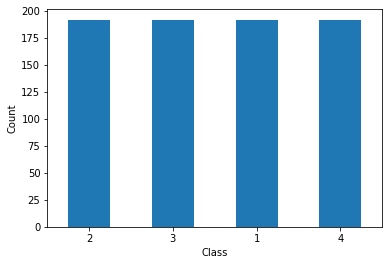

In [6]:
# Discretize the Heating Load (HL), done manually by looking at the ranges of the data

q1 = df['heating_load'].quantile(0.25)
q2 = df['heating_load'].quantile(0.5)
q3 = df['heating_load'].quantile(0.75)
print(q1, q2, q3)

discrete_HL = []
for i, row in df.iterrows():
    hl = row['heating_load']
    if hl <= q1:
        discrete_HL.append(1)
    elif hl <= q2:
        discrete_HL.append(2)
    elif hl <= q3:
        discrete_HL.append(3)
    else:
        discrete_HL.append(4)
        
hl_df = df.iloc[: , :8]
hl_df['discrete_heating_load'] = discrete_HL
#hl_df['discrete_heating_load'].hist()
hl_df['discrete_heating_load'].value_counts(sort=False).plot.bar(rot=0)
plt.xlabel("Class")
plt.ylabel("Count")
plt.savefig("target_var_classification", dpi=300)

In [7]:
# Set target and data
y = hl_df['discrete_heating_load']
X = hl_df.drop(["discrete_heating_load"], axis=1)

# Standardize training data, pandas automatically applies functions column-wise
X = (X - X.mean())/X.std()

### Compare models: Two-level (nested) cross-validation

For baseline: Compute the largest class on the training data, and predict everything in the test data as belonging to that class. 
<br/>-> corresponding to logistic regression with bias term and no features.

For multinomial regression: Inner fold is estimating lambda, the complexity controlling parameter (called C in sklearn)

For KNN: Inner fold is estimating K, the number of neighbours in the algorithm


In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

In [9]:
def two_level_cross_validation(X, y, k1, k2, p_grid_knn, p_grid_reg):
    """Performs a two level cross validation for logistic regression, KNN and a baseline classifier.

    Parameters
    ----------
    X: dataframe
        The input feature from which we want to make the prediction

    y: single column dataframe
        The target for X
    
    k1: int
        The number of folds for the first level of the cross validation
    
    k2: int
        The number of folds for the second level of the cross validation

    p_grid_knn: dictionary{string, list of values}
        The parameters to be tested and compared on the model for KNN
    
    p_grid_reg: dictionary{string, list of values}
        The parameters to be tested and compared on the model for KNN
    
    Returns
    -------
    res: dataframe
        Returns the best parameters found at each fold with the associated error for each model.

    """
    # Define table for output
    res = {"outer_fold": [], "KNN_k_i": [], "KNN_test_error_i" : [], "reg_lambda_i" : [], "reg_test_error_i" : [], "baseline_test_error_i": []}
    res["outer_fold"] = range(k1)

    dummy_errors = []
    cv_outer = KFold(n_splits=k1, shuffle=True) #outer cross validation obj
    for train_ix, test_ix in cv_outer.split(X):
        # Split data
        x_train, x_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        
        # Do baseline estimation error and append to table
        dummy = DummyClassifier(strategy='most_frequent')
        dummy.fit(x_train, y_train)
        dummy_errors.append(1 - dummy.score(x_test, y_test))

        
        cv_inner = KFold(n_splits=k2, shuffle=True) #inner cross validation obj

        # Model objects
        knn = KNeighborsClassifier()
        reg = LogisticRegression(multi_class='multinomial')

        # Exhaustive search over specified parameter values (p_grid_...) (with the inner cross validation) for the estimators
        search_knn = GridSearchCV(knn, p_grid_knn, scoring='accuracy', cv=cv_inner, refit=True)
        search_reg = GridSearchCV(reg, p_grid_reg, scoring='accuracy', cv=cv_inner, refit=True)

        # Do actual search on the current training split
        res_knn = search_knn.fit(x_train, y_train)
        res_reg = search_reg.fit(x_train, y_train)

        # Get best performing model on training set from inner fold
        best_knn = res_knn.best_estimator_
        best_reg = res_reg.best_estimator_

        # Get the parameter for the best performing model within the fold
        best_param_knn = res_knn.best_params_['n_neighbors'] #i.e. K
        best_param_reg = res_reg.best_params_['C'] #i.e. lambda

        # Evaluate best scoring estimators on training set
        y_pred_knn = best_knn.predict(x_test)
        y_pred_reg = best_reg.predict(x_test)
        
        # Check error for best estimators on current test split
        err_knn = 1 - accuracy_score(y_test, y_pred_knn)
        err_reg = 1 - accuracy_score(y_test, y_pred_reg)
        
        # Append values to respective lists in outside dict
        res["KNN_k_i"].append(best_param_knn)
        res["KNN_test_error_i"].append(err_knn)
        res["reg_lambda_i"].append(best_param_reg)
        res["reg_test_error_i"].append(err_reg)
    
    # insert baseline errors for all i into dict
    res['baseline_test_error_i'] = dummy_errors

    # returned transformed dict as pandas df
    return pd.DataFrame.from_dict(data=res)

In [18]:
# Obtain some intuition on the ranges of lambda and k by plotting the average error on a given set of train-test splits as functions of lambda and k
ks = range(1, 30)
lambdas = np.linspace(1, 3000, num=200)

n_runs = 10
errors_knn = [[] for _ in range(n_runs)]
errors_reg = [[] for _ in range(n_runs)]

for run in range(1, n_runs):
    x_train_, x_test_, y_train_, y_test_ = train_test_split(X,y, test_size=0.33, shuffle=True) # shuffle every run - important
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train_, y_train_)
        errors_knn[run].append(1- knn.score(x_test_, y_test_))

    for l in lambdas:
        reg = LogisticRegression(C=l, multi_class='multinomial')
        reg.fit(x_train_, y_train_)
        errors_reg[run].append(1- reg.score(x_test_, y_test_))

In [19]:
# Transform 
errors_knn.pop(0)
errors_reg.pop(0)
err_knn = np.array(errors_knn).T
err_reg = np.array(errors_reg).T

# Take averages across runs for a given k/lambda
avg_err_knn = [e.mean() for e in err_knn]
avg_err_reg = [e.mean() for e in err_reg]

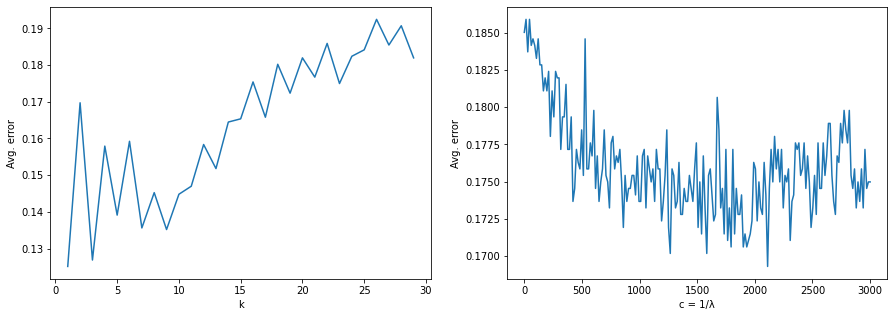

In [20]:
# plot error for the hyperparams 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(ks, avg_err_knn)
ax2.plot(lambdas, avg_err_reg)
ax1.set_xlabel("k")
ax1.set_ylabel("Avg. error")
ax2.set_xlabel("c = 1/λ")
ax2.set_ylabel("Avg. error")
plt.show()
fig.savefig("errors_knn_reg", dpi=300)

In [25]:
# Number of folds in inner and outer cross validation
k_1, k_2 = 10, 10

# Parameter grids. I.e. what vals to check for optimality in respective model (for inner folds)
# Parameter grids are based on trial and error
p_grid_knn = {"n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]} 
p_grid_reg = {"C": [1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000]}

cross_val_table = two_level_cross_validation(X, y, k_1, k_2, p_grid_knn, p_grid_reg)

In [26]:
display(cross_val_table)

,outer_fold,KNN_k_i,KNN_test_error_i,reg_lambda_i,reg_test_error_i,baseline_test_error_i
0,0,1,0.077922,1650,0.168831,0.766234
1,1,1,0.090909,1600,0.220779,0.779221
2,2,1,0.064935,1900,0.168831,0.779221
3,3,1,0.038961,1650,0.129870,0.779221
4,4,1,0.064935,1650,0.051948,0.792208
5,5,1,0.116883,1700,0.181818,0.779221
6,6,1,0.103896,1700,0.207792,0.818182
7,7,1,0.064935,1750,0.220779,0.805195
8,8,1,0.157895,1600,0.144737,0.802632
9,9,1,0.144737,1600,0.276316,0.802632


In [27]:
# Choose k and lambda that appear most frequently in the crossvalidation table
k_optimals = list(cross_val_table['KNN_k_i'])
c_optimals = list(cross_val_table['reg_lambda_i'])

K = max(set(k_optimals), key = k_optimals.count)
c = max(set(c_optimals), key = c_optimals.count)
print(f"K = {K}, c = {c}")

K = 1, c = 1600


### Statistical evaluation: McNemar's test

Compare the three previously obtained models pairwise with a *McNemar's test*. The McNemar’s test is a paired nonparametric or distribution-free statistical hypothesis test. We find p-values and confidence intervals for the pairwise tests.

Based on the two-level cross-validation table obtained above, and multiple runs of the code, we choose the hyperparameters for the kNN and LogisticRegression (Multinomial regression, that is) model that seems optimal. That is,
```
K = 1, lambda = 1/1600 (C = 1600),
``` 
while the baseline model remains the same. 

In [28]:
# Create models
dummy = DummyClassifier(strategy='most_frequent')
knn = KNeighborsClassifier(n_neighbors=K)
reg = LogisticRegression(C=c, multi_class='multinomial')


# Split data into random training and testing samples, we use normal holdout and train all models on the same splits
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Train classifiers predict
y_pred_dummy = dummy.fit(x_train, y_train).predict(x_test)
y_pred_knn = knn.fit(x_train, y_train).predict(x_test)
y_pred_reg = reg.fit(x_train, y_train).predict(x_test)

# Create list of 2-tuples with pairs to compare predictions from
# That is: (kNN, baseline), (kNN, regression), (regression, baseline)
prediction_pairs = [(y_pred_knn, y_pred_dummy), (y_pred_knn, y_pred_reg), (y_pred_reg, y_pred_knn), (y_pred_reg, y_pred_dummy)] 

#### **Some theory:**
(Algorithm taken from: Tue Herlau, Mikkel N. Schmidt and Morten Mørup: "Introduction to Machine Learning and Data Mining", Lecture notes, Spring 2022, version 1.0, p.204 - 207.)

##### **1. Contingency table**
A contingency table is a tabulation or count of two categorical variables. In the case of the McNemar’s test, we are interested in binary variables correct/incorrect or yes/no for a control and a treatment or two cases. This is called a 2×2 contingency table. Example for two classifiers/models, C_1 and C_2, is given below:

|               | C_2 correct | C_2 incorrect |
|---------------|-------------|---------------|
| **C_1 correct**   |      $n_{11}$      |       $n_{12}$       |
| **C_1 incorrect** |      $n_{21}$      |       $n_{22}$       |

##### **2. Hypothesis testing and the p-value**
Whats interesting is when our to classifiers *differs* in their predictions. Therefore, we say that C_1 is better than C_2 when $n_{12} > n_{21}$ . Note that if $n_{12} > n_{21}$, then 

$$\hat{r} = \frac{n_{12}}{(n_{12} + n_{21})} > \frac{1}{2}.$$

We want to test the null-hypotheses that is $p_{12} = p_{21}$, i.e., 

$$r = \frac{p_{12}}{p_{12} + p_{21}} = \frac{1}{2}.$$

We let our hypothesis' be:<br/>
$H_{0}$: C_1 has the same performance as C_2.<br/>
$H_{1}$: C_1 and C_2 have different performance.

Recal that the p-value is defined as the probability of observing a value of $n_{12}$ and $n_{21}$ more extreme, i.e. unlikely, than the one actually observed assuming H0 is true. That is, $r = \frac{1}{2}$. If we consider $m = min\{n_{12},n_{21}\}$ as the more extreme value, then we have that the p-value is

$$p = 2cdf_{binom}(m|\theta = \frac{1}{2}, N = n_{12} + n_{21}).$$

The lower the p-value, the more better is C_1 than C_2.

##### **3. Confidence interval for the McNemar's test**
We use p-values to see if C_1 is better than C_2, but we need a *confidence interval* to determine an interval that the performance difference most likely lies in. We therefore let $\theta_i$ with $i = 1,2$ denote the true chance that the classifier C_i is correct. We want to arrive at an interval for the difference in performance for C_1 and C_2. Namely:

$$ \theta = \theta_1 - \theta_2$$

Where $\theta > 0$ indicates that C_1 is better (more accurate) than C_2, and vice versa. We thus let the *estimated* difference in accuracy between C_1 and C_2 be denoted $\hat{\theta}$, which is given by:

$$ \hat{\theta} = \frac{n_{12} - n_{21}}{n} $$

where $n$ is the length of the test dataset. 

An *approximation* of the $(1 - \alpha)$-confidence nterval, $[\theta_L, \theta_U]$, is then given by

$$\theta_L = 2cdf_B^{-1}(\frac{\alpha}{2}|\alpha = f, \beta = g) - 1$$
$$\theta_U = 2cdf_B^{-1}(1 - \frac{\alpha}{2}|\alpha = f, \beta = g) - 1$$

where $cdf_B^{-1}()$ is the inverse cummulative Beta-distribution function, and $f()$ and $g()$ is given by

$$f = \frac{E_{\theta} + 1}{2}(Q-1), \quad g = \frac{1- E_{\theta}}{2}(Q-1)$$
$$E_{\theta} = \frac{n_{12} - n_{21}}{n}, \quad Q = \frac{n^2(n+1)(E_{\theta} + 1)(1 - E_{\theta})}{n(n_{12}+n_{21})-(n_{12}-n_{21})^2}$$

Note that the approximation of the CI only is useful when $n_{12} + n_{21} > 5$. This is true in our case.

#### Define functions

In [29]:
from scipy.stats import binom, beta

In [30]:
# Create contingency table
def contingency_table(y_pred_1, y_pred_2, y_true):
    """Creates a contingency table for two classifiers that has produced 
    two predictions for the binary target y_true. Assumes all input same shape
    
    Parameters
    ----------
    y_pred_1 : One dimentional np.array
        Prediction vector for model 1
    
    y_pred_2 : One dimentional np.array
        Prediction vector for model 2
    
    y_true : One dimentional vector
        True labels for the target variable
    
    Returns
    -------
    cont_table : 2x2 matrix
        The contingency table for the two models
    """
    correct_preds_1 = [1 if (y_pred_1[i] == y_true[i]) else 0 for i in range(len(y_pred_1))]
    correct_preds_2 = [1 if (y_pred_2[i] == y_true[i]) else 0 for i in range(len(y_pred_2))]
    
    n11, n12, n21, n22 = 0, 0, 0, 0
    
    for j in range(len(y_true)):
        n11 += correct_preds_1[j]*correct_preds_2[j]
        n12 += correct_preds_1[j]*(1-correct_preds_2[j])
        n21 += (1-correct_preds_1[j])*correct_preds_2[j]
        n22 += (1-correct_preds_1[j])*(1-correct_preds_2[j])
    
    return np.array([[n11, n12],[n21, n22]])

In [31]:
def p_value(n12, n21, theta):
    """Creates p-value based on the binomial distribution, given some contingency table (w/ n12, n21) and a theta
    
    Parameters
    -----------
    n12, n21: int
        Number of times classifier i was correct and classifier j incorrect
    theta: real
        Theta, probability of a single success
    
    Returns
    -------
    p: real
        p-value
    """
    m = min(n12, n21)
    N = n12 + n21
    p = 2*binom.cdf(m, N, theta)
    return p


In [32]:
def confidence_interval(alpha, n12, n21, n):
    """Creates an approximation (via the beta distribution) of the (1-alpha)-confidence interval for the estimated theta
    
    Parameters
    ----------
    alpha: real
        Threshold for (1-alpha) confidence interval
    n12, n21: int
        Number of times classifier i was correct and classifier j incorrect
    n: int
        Number of predictions

    Returns
    -------
    theta_L: real
        Lower bound for the confidence interval approximation
    theta_U: real
        Upper bound for the confidence interval approximation
    """
    E_theta = (n12 - n21)/n
    Q = ((n**2)*(n+1)*(E_theta + 1)*(1 - E_theta))/(n*(n12 + n21) - (n12 - n21)**2)
    f = ((E_theta + 1)/2)*(Q-1)
    g = ((1- E_theta)/2)*(Q-1)
    theta_L = 2*beta.ppf(alpha/2, f, g) - 1 #.ppf() calculates the inverse cummulative distribution function
    theta_U = 2*beta.ppf(1 - (alpha/2), f, g) - 1
    return theta_L, theta_U

#### Run algorithm: "The McNemar test for comparing classifiers"

In [33]:
n = len(y_pred_knn)
alpha = 0.05 # Standard. Yields a 95% confidence interval.

# Names of pairs of models to compare
pairs_names = ["(kNN, baseline)", "(kNN, regression)", "(regression, kNN)", "(regression, baseline)"]

# Define resulting dataframe
res = pd.DataFrame(columns=["pair", "estimated difference", "CI lower", "CI upper", "p-value"])
res["pair"] = pairs_names

In [34]:
# Create pairwise contingency tables:
contingency_tables = [] 
y_true = np.array(y_test)
for (pred1, pred2) in prediction_pairs:
    table = contingency_table(pred1, pred2, y_true)
    contingency_tables.append(table)

print("Pairwise contingency tables:")
print("-----------------------------")
for i in range(len(contingency_tables)):
    print(f"Pair = {pairs_names[i]}:")
    print(contingency_tables[i])

Pairwise contingency tables:
-----------------------------
Pair = (kNN, baseline):
[[ 54 171]
 [  2  27]]
Pair = (kNN, regression):
[[200  25]
 [ 13  16]]
Pair = (regression, kNN):
[[200  13]
 [ 25  16]]
Pair = (regression, baseline):
[[ 49 164]
 [  7  34]]


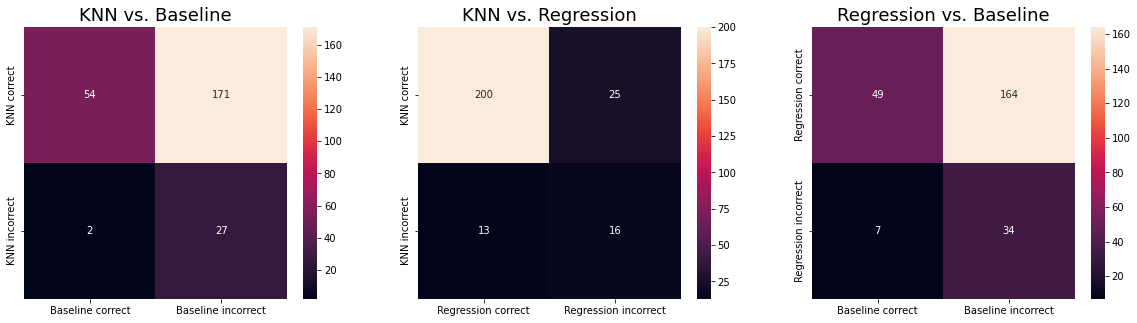

In [35]:
# Plot contingency tables as heatmaps
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
sns.heatmap(contingency_tables[0], ax=ax1, annot=True, fmt='d', cbar=True, yticklabels=["KNN correct", "KNN incorrect"], xticklabels=["Baseline correct","Baseline incorrect"])
sns.heatmap(contingency_tables[1], ax=ax2, annot=True, fmt='d', cbar=True, yticklabels=["KNN correct","KNN incorrect"], xticklabels=["Regression correct", "Regression incorrect"])
sns.heatmap(contingency_tables[3], ax=ax3, annot=True, fmt='d', cbar=True, yticklabels=["Regression correct", "Regression incorrect"], xticklabels=["Baseline correct","Baseline incorrect"])
ax1.set_title("KNN vs. Baseline", fontsize=18, loc='center')
ax2.set_title("KNN vs. Regression", fontsize=18, loc='center')
ax3.set_title("Regression vs. Baseline", fontsize=18, loc='center')
fig.savefig("contingency_tables", dpi=300, bbox_inches='tight')

In [36]:
# Unpack all n12 and n21 as 2-tuples (n12, n21) for all contingency tables
ns = []
for t in contingency_tables:
    ns.append((t[0][1], t[1][0]))

In [37]:
# Estimated difference column
est_diff = []
for (n12, n21) in ns:
    est_ = (n12 - n21) / n
    est_diff.append(est_)

res["estimated difference"] = est_diff

# CI lower and upper columns
CI_lowers = []
CI_uppers = []
for (n12, n21) in ns:
    CI_lower, CI_upper = confidence_interval(alpha, n12, n21, n)
    CI_lowers.append(CI_lower)
    CI_uppers.append(CI_upper)

res["CI lower"] = CI_lowers
res["CI upper"] = CI_uppers

# p-value column
p_vals = []
for (n12, n21) in ns:
    p = p_value(n12, n21, theta=0.5)
    p_vals.append(round(p, 6))

res["p-value"] = p_vals

# Add column for whether we can reject the null hypothesis or not
rej_h0 = [bool(p_vals[i] < alpha) for i in range(len(p_vals))]
res["reject H0"] = rej_h0

In [38]:
display(res)

,pair,estimated difference,CI lower,CI upper,p-value,reject H0
0,"(kNN, baseline)",0.665354,0.603357,0.723117,0.000000,True
1,"(kNN, regression)",0.047244,0.000080,0.094305,0.072951,False
2,"(regression, kNN)",-0.047244,-0.094305,-0.000080,0.072951,False
3,"(regression, baseline)",0.618110,0.549766,0.682120,0.000000,True


### Train logistic regression model

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [45]:
# Create new train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [46]:
# Train and predict with suitable lambda (c)
reg = LogisticRegression(C=c, multi_class='multinomial')
y_pred = reg.fit(x_train, y_train).predict(x_test)

In [47]:
reg.coef_

array([[  3.71843212,  10.9416639 ,  -9.68863845,  15.34883994,
        -20.15258539,   0.24502597, -17.15446407,   0.70878885],
       [  0.7934137 ,  -2.31791223,  -1.70367021,  -1.43748497,
        -23.29531873,   0.40384184, -13.85078396,   0.38200111],
       [-23.31750979, -20.07244384,  -0.68781079, -19.24122978,
          8.5749025 ,  -0.23422646,  14.50827717,  -0.65412617],
       [ 18.80566397,  11.44869217,  12.08011944,   5.3298748 ,
         34.87300162,  -0.41464134,  16.49697086,  -0.43666379]])

Accuracy score: 0.8188976377952756


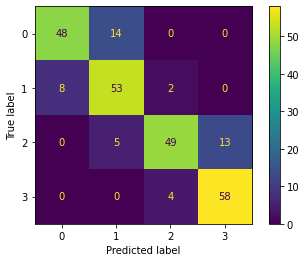

In [48]:
# Evaluate final multinomial regression classifier
acc = reg.score(x_test, y_test)
cm = confusion_matrix(y_test, y_pred)
#maybe have some sort of f1 score for multiclass?

print(f"Accuracy score: {acc}")
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot()

In [49]:
fig = cm_disp.figure_
fig.savefig("conf_matr", dpi=300, bbox_inches='tight')